# Setup

In [3]:
from conex import *
import torch
from pymonntorch import *

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Poisson Generator

In [8]:
class PoissionGenerator(Behavior) :

    def initialize(self, ng) : 
        self.offset = ng.network.iteration
        self.T = self.parameter("T", 50)
        self.lamda = self.parameter("lamda", 20)
        self.target = self.parameter("target", required = True)
        self.poisson = 0

    def forward(self, ng) : 
        pat = self.pattern(ng)
        if(pat == -1) : 
            ng.spikes[self.target] = torch.rand(len(self.target)) < 0
        else :
            self.poisson = (np.exp(-self.lamda) * (self.lamda ** (ng.network.iteration - self.offset))) / (np.math.factorial(ng.network.iteration - self.offset)) / ((np.exp(-self.lamda) * (self.lamda ** self.lamda)) / (np.math.factorial(self.lamda))*2)
            ng.spikes[self.target] = torch.rand(len(self.target)) <= self.poisson

    def pattern(self, ng) : 
        if(ng.network.iteration - self.offset > self.T) : 
            return -1   
        return 1

# Convergence Metric

In [14]:
def convergence_metric(sg, K, W_min = 0, W_max = 15) : 
    conv_rate = 0
    for i in range(K) : 
        conv_rate += torch.sum((W_max - sg['weights', 0][:,:,i])*(sg['weights', 0][:,:,i] - W_min), axis = 1) / 25
    
    conv_rate /= K
    return conv_rate
        

# Config

In [15]:
K = 30 # -> number of patterns
N = 8 # -> number of input-layers per pattern

# Define Network

In [16]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = N * K, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    # 341 : PoissionGenerator(T = 50, lamda = 20, target = [0, 1, 2, 3, 4]),
    800 : Recorder(['v', "I", 'trace']),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = K, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 1,
        R = 6,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    KWTA(k = 1),
    ActivityBaseHomeostasis(
        window_size = 300,
        activity_rate = 10,
        updating_rate = 0.8,
        decay_rate = 0.8
    ),
    Fire(),
    SpikeTrace(tau_s = 8),
    NeuronAxon(),
    
]) | ({
    800 : Recorder(['v', "I", "trace"]),
    801 : EventRecorder(['spikes'])
}))

sg = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(6, 6)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 25,
        a_plus = 0.5,
        a_minus = 0.3,
    ),
    WeightNormalization(norm = 100),
    WeightClip(w_max = 25, w_min = 0),
]) | ({
    800 : Recorder(["I", "weights"]),
}))

weights = torch.Tensor([1] * (K - 1) + [0] + [1] * (K - 1)) * 0.5
weight_shape = (1, 1, 1, 1, 2*K - 1)
weights = weights.view(weight_shape)


sg_lateral = SynapseGroup(net = net, src = ng2, dst = ng2, tag = "Proximal, inh", behavior= prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(weights = weights, weight_shape = weight_shape),
    LateralDendriticInput(inhibitory = True, current_coef = 25)
])| ({
    800 : Recorder(["I"]),
}))

# Simulate

In [18]:
net.initialize()

for i in range(K) : 
    for _ in range(3) : 
        ng1.add_behavior(342, PoissionGenerator(T = 50, lamda = 20, target = [j for j in range(N*i, N*(i + 1))]))
        net.simulate_iterations(100)
        ng1.remove_behavior(342)

# sg.remove_behavior(439)
# Resting phase
net.simulate_iterations(500)

# test-phase
ng2.remove_behavior(400) # Remove STDP
for i in range(K) : 
    ng1.add_behavior(342, PoissionGenerator(T = 50, lamda = 20, target = [j for j in range(N*i, N*(i + 1))]))
    net.simulate_iterations(100)
    ng1.remove_behavior(342)

Network['Network'](Neurons: tensor(270)|2 groups, Synapses: tensor(8100)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](240){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I', 'trace'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](30){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,pro

C:\Users\Asus\AppData\Local\Temp\ipykernel_31960\1415618111.py:15: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  self.poisson = (np.exp(-self.lamda) * (self.lamda ** (ng.network.iteration - self.offset))) / (np.math.factorial(ng.network.iteration - self.offset)) / ((np.exp(-self.lamda) * (self.lamda ** self.lamda)) / (np.math.factorial(self.lamda))*2)


100xBatch: 1/1 (100%) 870.213ms
100xBatch: 1/1 (100%) 460.730ms
100xBatch: 1/1 (100%) 501.660ms
100xBatch: 1/1 (100%) 579.449ms
100xBatch: 1/1 (100%) 668.246ms
100xBatch: 1/1 (100%) 885.598ms
100xBatch: 1/1 (100%) 935.494ms
100xBatch: 1/1 (100%) 915.552ms
100xBatch: 1/1 (100%) 1098.062ms
100xBatch: 1/1 (100%) 1137.956ms
100xBatch: 1/1 (100%) 1283.567ms
100xBatch: 1/1 (100%) 1241.680ms
100xBatch: 1/1 (100%) 1292.541ms
100xBatch: 1/1 (100%) 1398.260ms
100xBatch: 1/1 (100%) 1978.709ms
100xBatch: 1/1 (100%) 1453.113ms
100xBatch: 1/1 (100%) 1498.990ms
100xBatch: 1/1 (100%) 1591.745ms
100xBatch: 1/1 (100%) 1673.524ms
100xBatch: 1/1 (100%) 1825.116ms
100xBatch: 1/1 (100%) 1877.978ms
100xBatch: 1/1 (100%) 1973.720ms
100xBatch: 1/1 (100%) 2053.512ms
100xBatch: 1/1 (100%) 1940.806ms
100xBatch: 1/1 (100%) 2121.330ms
100xBatch: 1/1 (100%) 2535.218ms
100xBatch: 1/1 (100%) 2220.062ms
100xBatch: 1/1 (100%) 2141.271ms
100xBatch: 1/1 (100%) 2273.921ms
100xBatch: 1/1 (100%) 2369.662ms
100xBatch: 1/1 (10

# Visualization

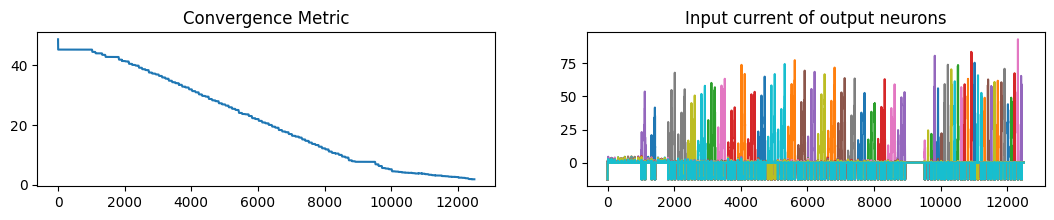

In [19]:
plt.figure(figsize = (13, 2))

plt.subplot(1, 2, 1)
plt.plot(convergence_metric(sg, K, W_max = 12))
plt.title("Convergence Metric")

plt.subplot(1, 2, 2)
plt.plot(ng2['I', 0][2:])
plt.title("Input current of output neurons")

plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_31960\476093100.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue", marker = "|", markersize = 10, markeredgewidth=1.4)


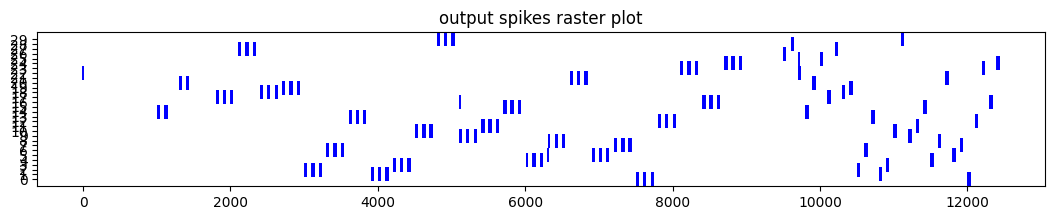

In [22]:
plt.figure(figsize = (13, 2))

plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue", marker = "|", markersize = 10, markeredgewidth=1.4)
plt.title("output spikes raster plot")
plt.yticks([i for i in range(K)])

plt.show()

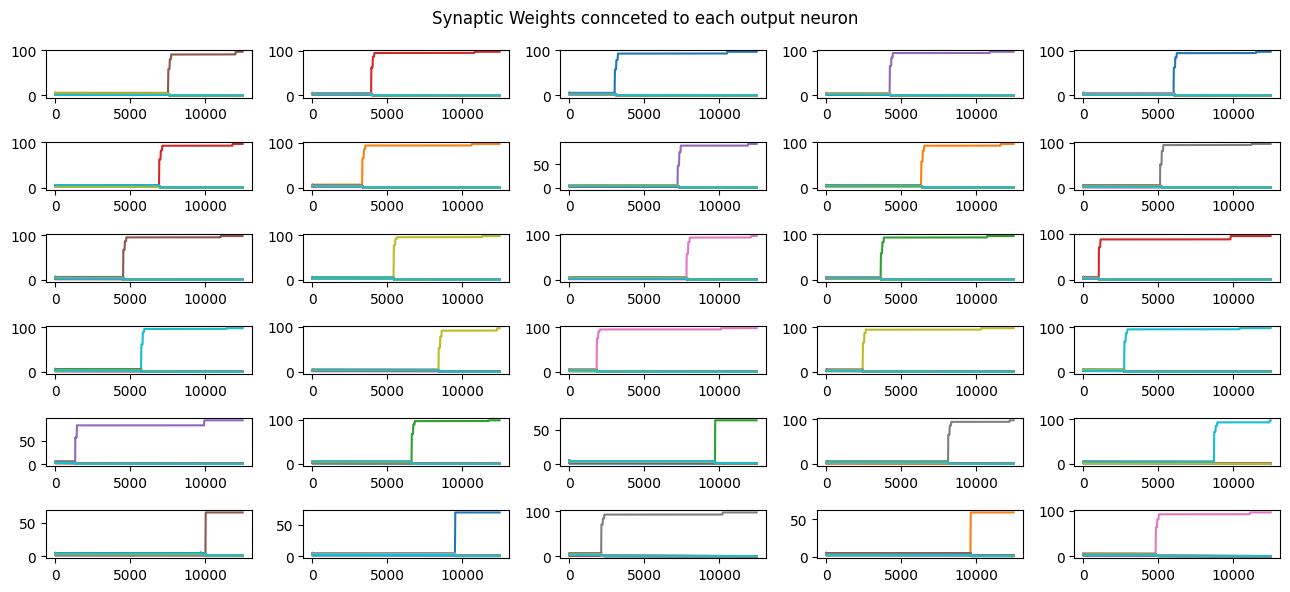

In [21]:
plt.figure(figsize = (13, 6))
colors = ['blue', 'red', 'orange', 'green', 'purple', "gray", "lightblue", "pink", "yellow", "black"]
for i in range(K) : 
    A = sg['weights', 0][:,:,i]
    for j in range(K) : 
        plt.subplot(6, 5, i + 1)
        plt.plot(torch.sum(A[:,(j*N):(j + 1)*N], axis = 1), label = f"pattern {j + 1}")
    # plt.legend()
plt.suptitle(f"Synaptic Weights connceted to each output neuron")
plt.tight_layout()
plt.show()    